In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("questions.csv", engine='python',  on_bad_lines='skip')

In [5]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
4089,4089,8176,8177.0,How can I fix the head lamp of my car?,I hit the left back side (plastic bit) of my f...,0.0
1930,1930,3861,3862.0,What's the safest and cheapest place to buy go...,Is buying WoW gold safe?,0.0
9428,9428,18829,18830.0,How can I find a job in China?,How can one find a job outside of China?,0.0
7687,7687,15355,15356.0,How do I get addmision in MIT?,How can I be selected in mit?,1.0
9628,9628,19227,19228.0,Why are the farthest galaxies considered the o...,Why didn't Tamil get world recognition as one ...,0.0


In [6]:
df.shape

(14368, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14368 entries, 0 to 14367
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            14368 non-null  int64  
 1   qid1          14368 non-null  int64  
 2   qid2          14367 non-null  float64
 3   question1     14367 non-null  object 
 4   question2     14367 non-null  object 
 5   is_duplicate  14367 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 673.6+ KB


In [8]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,1
question1,1
question2,1
is_duplicate,1


In [9]:
df = df.dropna()


In [10]:
df.duplicated().sum()

np.int64(0)

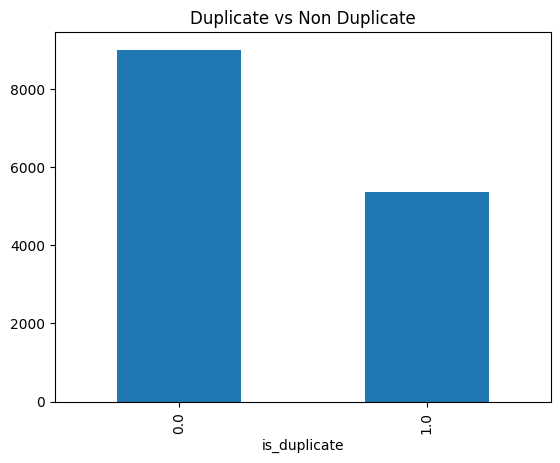

In [11]:
import matplotlib.pyplot as plt

df['is_duplicate'].value_counts().plot(kind='bar')
plt.title("Duplicate vs Non Duplicate")
plt.show()


In [12]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 28680
Number of questions getting repeated 53


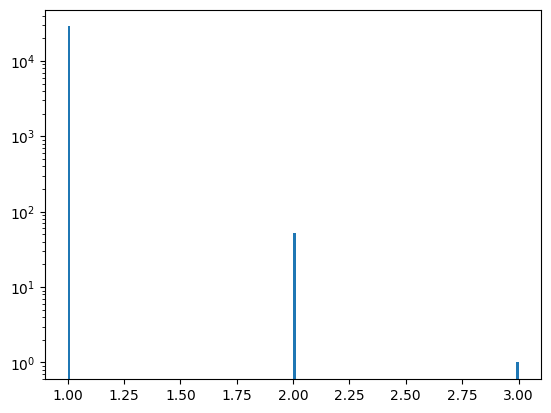

In [13]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# **Text Cleaning**

In [14]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


# **Stopword Removal + Lemmatization**

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Feature Engineering**

In [16]:
def word_overlap(q1, q2):
    s1 = set(q1.split())
    s2 = set(q2.split())
    return len(s1 & s2)

df['q1_len'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x: len(x.split()))

df['len_diff'] = abs(df['q1_len'] - df['q2_len'])

df['word_overlap'] = df.apply(
    lambda x: word_overlap(x['question1'], x['question2']), axis=1
)


# **EDA on New Features**

In [17]:
df[['q1_len', 'q2_len', 'len_diff', 'word_overlap']].describe()


,q1_len,q2_len,len_diff,word_overlap
count,14367.000000,14367.000000,14367.000000,14367.000000
mean,5.509223,5.566298,1.899631,2.599777
std,3.009851,3.338929,2.529696,1.659995
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000,2.000000
50%,5.000000,5.000000,1.000000,2.000000
75%,7.000000,7.000000,2.000000,3.000000
max,41.000000,103.000000,88.000000,19.000000


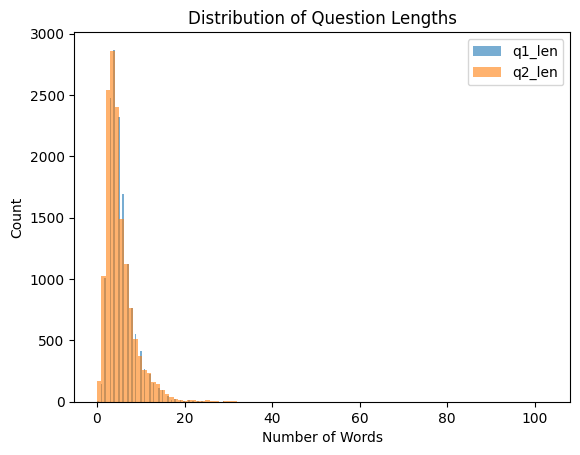

In [18]:
plt.hist(df['q1_len'], bins=100, alpha=0.6, label='q1_len')
plt.hist(df['q2_len'], bins=100, alpha=0.6, label='q2_len')
plt.legend()
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


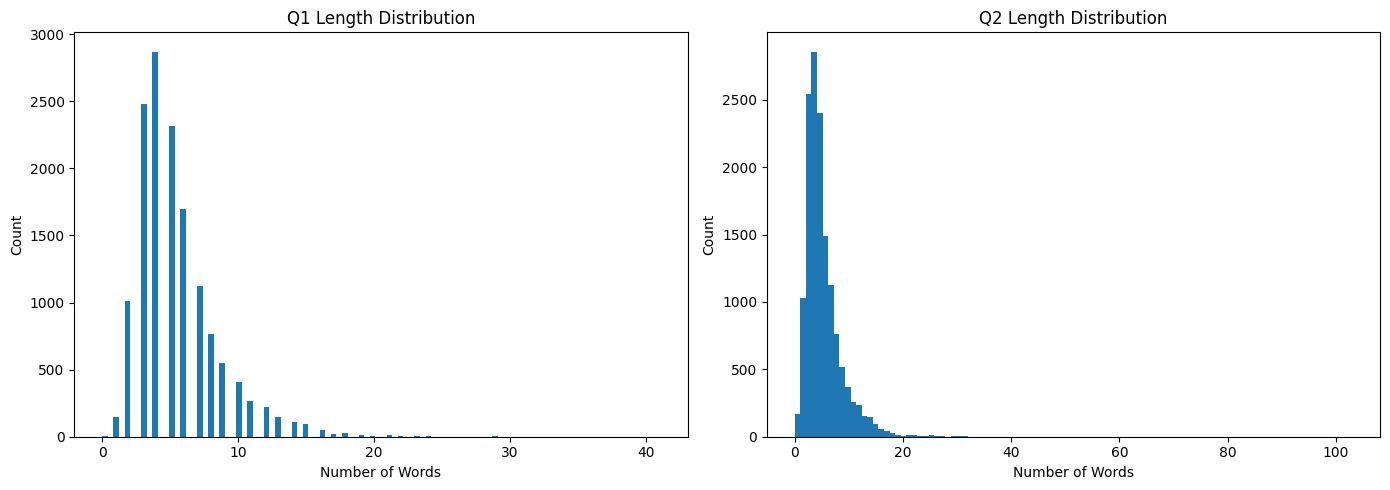

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist(df['q1_len'], bins=100)
axes[0].set_title("Q1 Length Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Count")

axes[1].hist(df['q2_len'], bins=100)
axes[1].set_title("Q2 Length Distribution")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


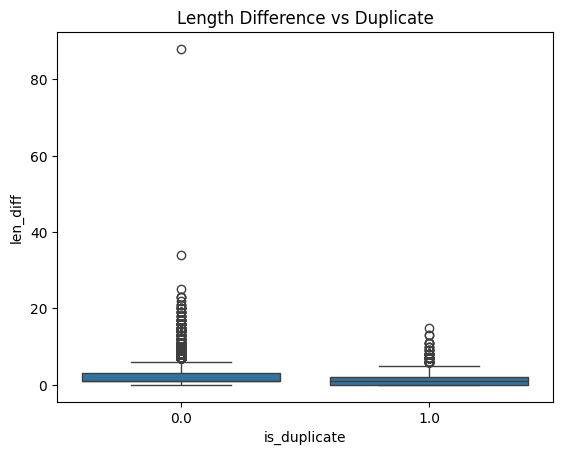

In [20]:
import seaborn as sns

sns.boxplot(x='is_duplicate', y='len_diff', data=df)
plt.title("Length Difference vs Duplicate")
plt.show()


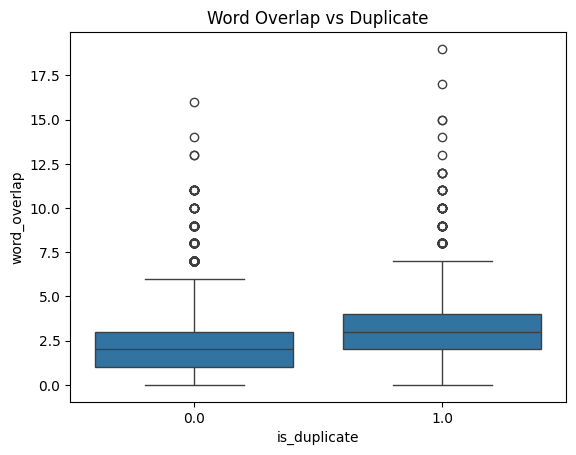

In [21]:
sns.boxplot(x='is_duplicate', y='word_overlap', data=df)
plt.title("Word Overlap vs Duplicate")
plt.show()


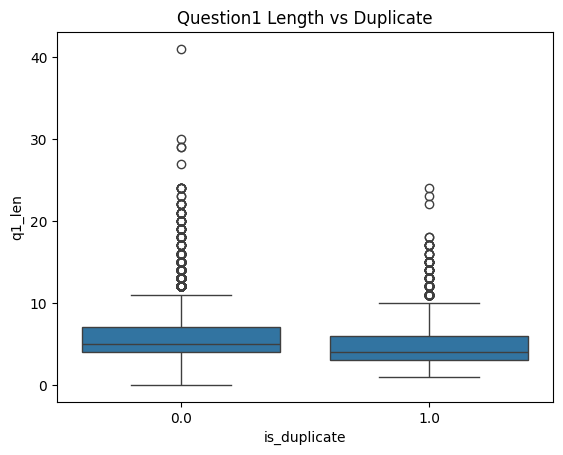

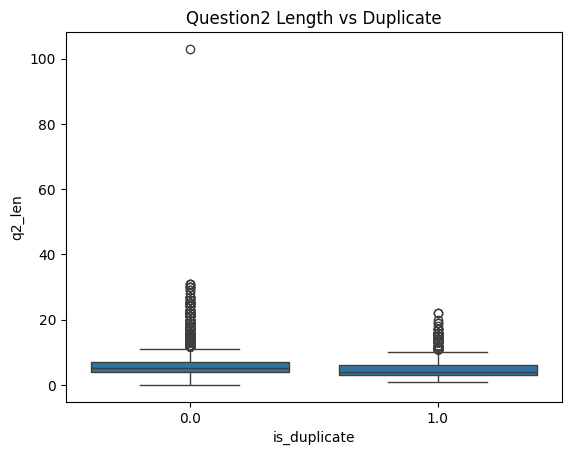

In [22]:
sns.boxplot(x='is_duplicate', y='q1_len', data=df)
plt.title("Question1 Length vs Duplicate")
plt.show()

sns.boxplot(x='is_duplicate', y='q2_len', data=df)
plt.title("Question2 Length vs Duplicate")
plt.show()


# **Correlation Check**

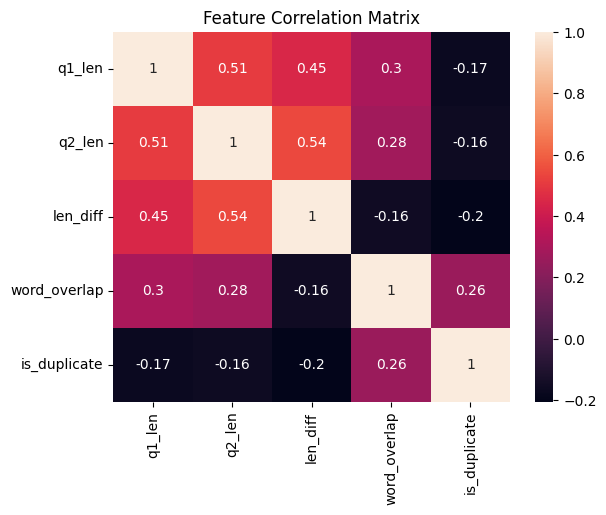

In [23]:
df[['q1_len', 'q2_len', 'len_diff', 'word_overlap', 'is_duplicate']].corr()
sns.heatmap(
    df[['q1_len', 'q2_len', 'len_diff', 'word_overlap', 'is_duplicate']].corr(),
    annot=True
)
plt.title("Feature Correlation Matrix")
plt.show()


# **TF-IDF Vectorization**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=30000)

q1_tfidf = tfidf.fit_transform(df['question1'])
q2_tfidf = tfidf.transform(df['question2'])


In [25]:
import scipy.sparse as sp

extra_features = df[['len_diff', 'word_overlap']]

X = sp.hstack((q1_tfidf, q2_tfidf, extra_features.values))
y = df['is_duplicate']


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Training accuracy
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Validation/Test accuracy
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_acc)
print("Validation/Test Accuracy:", test_acc)


Training Accuracy: 0.8607848255459846
Validation/Test Accuracy: 0.7352122477383438


In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      1836
         1.0       0.67      0.53      0.59      1038

    accuracy                           0.74      2874
   macro avg       0.72      0.69      0.70      2874
weighted avg       0.73      0.74      0.73      2874



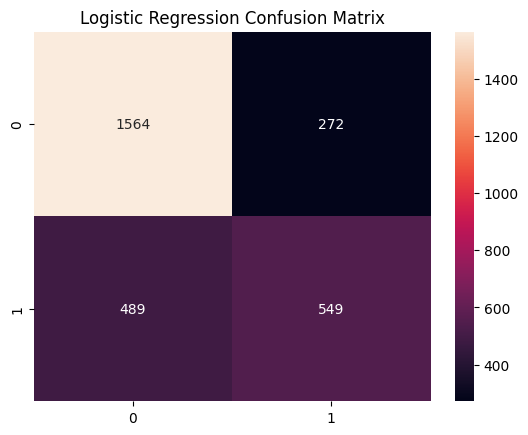

In [30]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [32]:
# Train accuracy
rf_train_pred = rf_model.predict(X_train)
rf_train_acc = accuracy_score(y_train, rf_train_pred)

# Validation/Test accuracy
rf_test_pred = rf_model.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("🌲 Random Forest Train Accuracy:", rf_train_acc)
print("🌲 Random Forest Validation/Test Accuracy:", rf_test_acc)

print(classification_report(y_test, rf_test_pred))


🌲 Random Forest Train Accuracy: 0.8829722439745933
🌲 Random Forest Validation/Test Accuracy: 0.7379958246346555
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81      1836
         1.0       0.69      0.50      0.58      1038

    accuracy                           0.74      2874
   macro avg       0.72      0.69      0.69      2874
weighted avg       0.73      0.74      0.73      2874



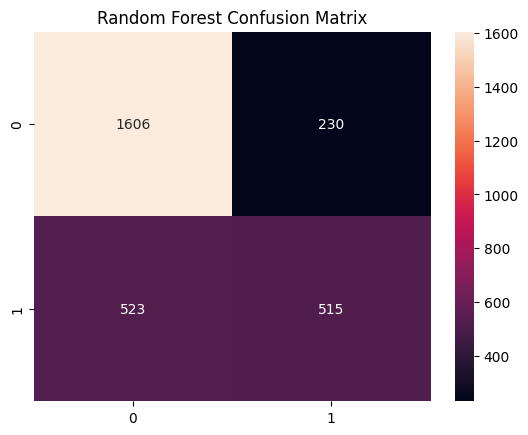

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

rf_cm = confusion_matrix(y_test, rf_test_pred)

sns.heatmap(rf_cm, annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

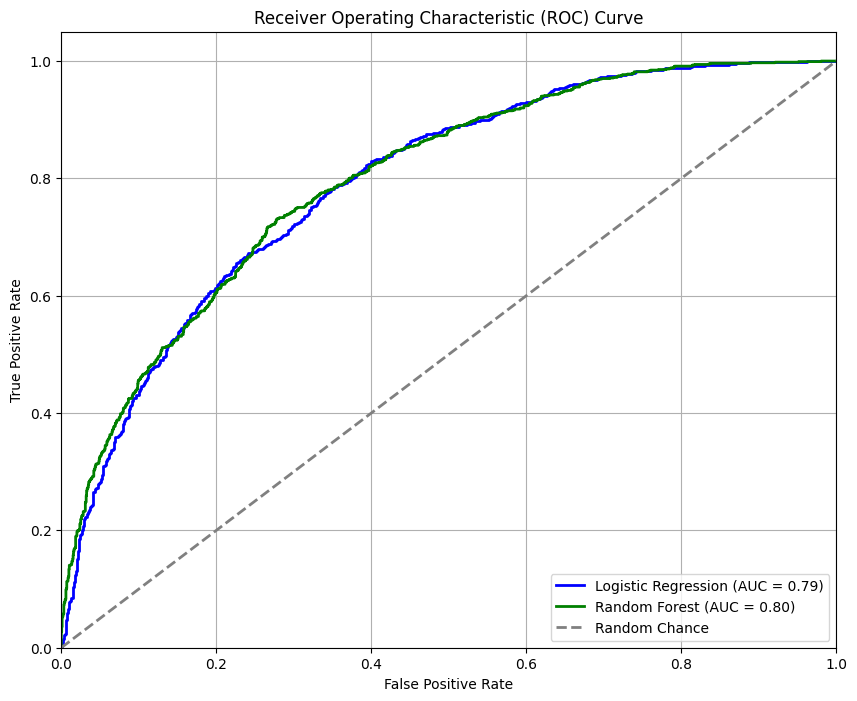

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for Logistic Regression
y_pred_proba_lr = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Get predicted probabilities for Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()